In [ ]:
# Importing the necessary libraries
import os
from random import sample
from torch.utils.data import dataloader
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
# making paths to generalise dataset directories 
ROOT_PATH = os.path.dirname(os.path.abspath("__file__"))
DATA_DIR = os.path.join(ROOT_PATH, 'Dataset_1\\')

In [ ]:
# listing all the classes present in the dataset
folder_array = os.listdir(DATA_DIR)
print(folder_array, type(folder_array))

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] <class 'list'>


In [ ]:
# Counting the number of images per class
# Already reduced size from somewhat around 3000 to 450

for i in folder_array:
    # making folder path
    class_folder_path=DATA_DIR+str(i)

    # folder 
    print(class_folder_path)

    # counter per folder
    _, _, files = next(os.walk(class_folder_path))
    file_count = len(files)
    print(file_count)

C:\Users\HP\Downloads\AI_Proj\Dataset_1\A
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\B
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\C
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\D
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\del
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\E
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\F
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\G
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\H
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\I
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\J
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\K
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\L
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\M
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\N
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\nothing
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\O
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\P
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\Q
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\R
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\S
450
C:\Users\HP\Downloads\AI_P

In [ ]:
# getting normalization values for the dataset

dataset_1_path = DATA_DIR

def get_dataset_for_normalization_values(data_path):
    dataset_training_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform= dataset_training_transforms)
    dataset = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle = False)
    return dataset

dataset_1 = get_dataset_for_normalization_values(dataset_1_path)


In [ ]:
# function to calculate mean and standard deviation of the dataset inorder to feed it for the transformations during preprcoessing.

def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_image_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch,images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    mean /= total_image_count
    std /= total_image_count

    return mean,std

In [ ]:
mean_1, std_1 = get_mean_and_std(dataset_1)

In [ ]:
# loading/preparing the dataset by applying some preprocessing and augmentation techniques.

def load_dataset(path, test_split, val_split, batch_size, input_size, mean_val, std_dev, len_size_flag):

    transform_dict = {'src' : transforms.Compose(
        [transforms.Resize(224),
         transforms.RandomHorizontalFlip(p=.25),
         transforms.RandomRotation(degrees=15),
         transforms.ToTensor(),
         transforms.Normalize(mean = mean_val, std = std_dev)])}
    
    data = datasets.ImageFolder(root = path, transform= transform_dict['src'])
    train_size = int(len(data)*(1-(test_split + val_split)))
    test_size = int(len(data)*test_split) 
    val_size = int(len(data)*val_split)

    print(data)
    print("SPLIT COUNTS", train_size,test_size,val_size)
#     logically the data was not fitting into the total logic of split so had to make the change, becuase of even and odd number of files.
    if len_size_flag:
        val_size=val_size+1
  
    
    train, test, val = torch.utils.data.random_split(data,[train_size, test_size, val_size])
    data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_test = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_val = torch.utils.data.DataLoader(val, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
# splitting the dataset into train, test and validation splits.
training_1, testing_1, validation_1 = load_dataset(path=dataset_1_path, test_split=0.3, val_split=0.1, batch_size=32, input_size=(224,224), mean_val=mean_1, std_dev=std_1, len_size_flag=False)

Dataset ImageFolder
    Number of datapoints: 13050
    Root location: C:\Users\HP\Downloads\AI_Proj\Dataset_1\
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.25)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5197, 0.4998, 0.5150]), std=tensor([0.2025, 0.2315, 0.2404]))
           )
SPLIT COUNTS 7830 3915 1305


In [ ]:
# function to train the dataset as well as testing on the validation set.

def train(num_epochs, model, device, train_loader, val_loader, criterion, optimizer, t_loss, t_acc, v_loss, v_acc):

    total_steps = len(train_loader)
    print('Training starts...........')
    for epoch in range(num_epochs):
        epo_loss = []
        epo_acc = []
        epo_val_loss = []
        epo_val_acc = []
        print('')
        print('Epoch {}'.format(epoch+1))
        for i, data in enumerate(train_loader):
            model.train()
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            total = labels.size(0)
            _,predicted = torch.max(output.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = (correct/total)*100


            correct_val = 0
            total_val = 0
            for data in val_loader:
                model.eval()
                with torch.no_grad():
                    images_val, labels_val = data[0].to(device), data[1].to(device)
                    outputs_val = model(images_val)
                    val_loss = criterion(outputs_val, labels_val)
                    _,predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()
                    val_accuracy = (correct_val/total_val)*100

            if (i + 1) % 81 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Training_loss: {:.4f}, Training_accuracy: {:.2f}%, Validation_loss: {:.4f}, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy, val_loss.item(), val_accuracy))
                epo_loss.append(loss.item())
                epo_acc.append(accuracy)
                epo_val_loss.append(val_loss.item())
                epo_val_acc.append(val_accuracy)

        t_loss.append(statistics.mean(epo_loss))
        t_acc.append(statistics.mean(epo_acc))
        v_loss.append(statistics.mean(epo_val_loss))
        v_acc.append(statistics.mean(epo_val_acc))

    return model

In [ ]:
# function to test the dataset on the test set.

def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0 
        test_loss = 0
        y_pred = []
        y_true = [] 
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_loss /= len(test_loader)
            y_pred.extend(predicted.data.cpu().numpy()) #Save Predictions
            y_true.extend(labels.data.cpu().numpy()) # Save Truth

        print('Test Accuracy of the model on the {} test images: {} having an average test loss: {:.4f}'
            .format(total, (correct / total) * 100, test_loss))
    
    return y_pred, y_true

In [ ]:
# function to make an evaluation metrics i.e. confusion matrix

def make_confusion_matrix(y_pred,y_true):
    classes = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    n_classes = len(classes)
    #Build Confusion Matrix
    cf_matrix = confusion_matrix(y_true,y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*n_classes,index = [ i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (30,15))
    sns.heatmap(df_cm,annot=True)

# **ResNet**

In [ ]:
# defining the resnet18 model.
resnet_model = models.resnet18(pretrained=False)

C:\Users\HP\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# setting the basic hyperparameters like learning rate, optimizer, loss function and number of epochs used for training the model.
lr = 0.001
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 30

In [ ]:
# checking to see if GPU is availabe and hence putting the model on GPU or "cuda", otherwise "cpu".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
resnet_model.to(device) 

Device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# defining empty list for training and validation loss and accuracies.
resnet_training_loss = []
resnet_training_accuracies = []
resnet_val_loss = []
resnet_val_accuracies = []

In [ ]:
# training the resnet model on the given dataset.
start = time.time()
resnet_dataset1 = train(num_epochs, resnet_model, device, training_1, validation_1, criterion, optimizer,
                        resnet_training_loss, resnet_training_accuracies, resnet_val_loss, resnet_val_accuracies)
end = time.time()
time_taken = end-start
print('Time Taken by ResNet:', time_taken)

Training starts...........

Epoch 1
Epoch [1/30], Step [81/245], Training_loss: 2.2891, Training_accuracy: 31.25%, Validation_loss: 2.8877, Validation Accuracy: 21.76%
Epoch [1/30], Step [162/245], Training_loss: 1.3877, Training_accuracy: 50.00%, Validation_loss: 1.7298, Validation Accuracy: 42.07%
Epoch [1/30], Step [243/245], Training_loss: 1.5515, Training_accuracy: 53.12%, Validation_loss: 1.9880, Validation Accuracy: 38.70%

Epoch 2
Epoch [2/30], Step [81/245], Training_loss: 0.9534, Training_accuracy: 62.50%, Validation_loss: 1.1227, Validation Accuracy: 69.20%
Epoch [2/30], Step [162/245], Training_loss: 0.6558, Training_accuracy: 78.12%, Validation_loss: 0.9323, Validation Accuracy: 67.74%
Epoch [2/30], Step [243/245], Training_loss: 0.7507, Training_accuracy: 68.75%, Validation_loss: 0.6614, Validation Accuracy: 73.64%

Epoch 3
Epoch [3/30], Step [81/245], Training_loss: 0.4845, Training_accuracy: 84.38%, Validation_loss: 0.4614, Validation Accuracy: 75.02%
Epoch [3/30], Step


Epoch 21
Epoch [21/30], Step [81/245], Training_loss: 0.0459, Training_accuracy: 96.88%, Validation_loss: 0.0281, Validation Accuracy: 96.32%
Epoch [21/30], Step [162/245], Training_loss: 0.1257, Training_accuracy: 93.75%, Validation_loss: 0.1479, Validation Accuracy: 98.16%
Epoch [21/30], Step [243/245], Training_loss: 0.2849, Training_accuracy: 93.75%, Validation_loss: 0.0918, Validation Accuracy: 94.18%

Epoch 22
Epoch [22/30], Step [81/245], Training_loss: 0.0205, Training_accuracy: 100.00%, Validation_loss: 0.0165, Validation Accuracy: 99.23%
Epoch [22/30], Step [162/245], Training_loss: 0.0105, Training_accuracy: 100.00%, Validation_loss: 0.1133, Validation Accuracy: 95.79%
Epoch [22/30], Step [243/245], Training_loss: 0.1171, Training_accuracy: 96.88%, Validation_loss: 0.2075, Validation Accuracy: 98.93%

Epoch 23
Epoch [23/30], Step [81/245], Training_loss: 0.0067, Training_accuracy: 100.00%, Validation_loss: 0.0059, Validation Accuracy: 99.39%
Epoch [23/30], Step [162/245], T

In [ ]:
# saving the model weights and accuracies for future reference.
torch.save(resnet_dataset1, f'resnet_dataset1_{lr}.pt')
np.savez(f'resnet_dataset1_{lr}_training_loss.npz', resnet_training_loss)
np.savez(f'resnet_dataset1_{lr}_training_accuracies.npz', resnet_training_accuracies)
np.savez(f'resnet_dataset1_{lr}_val_loss.npz', resnet_val_loss)
np.savez(f'resnet_dataset1_{lr}_val_accuracies.npz', resnet_val_accuracies)

In [ ]:
# testing the dataset on the test set and returning predicted and truth values.
resnet_y_pred , resnet_y_true = test(resnet_dataset1, device, testing_1)

Test Accuracy of the model on the 3915 test images: 99.18263090676885 having an average test loss: 0.0000


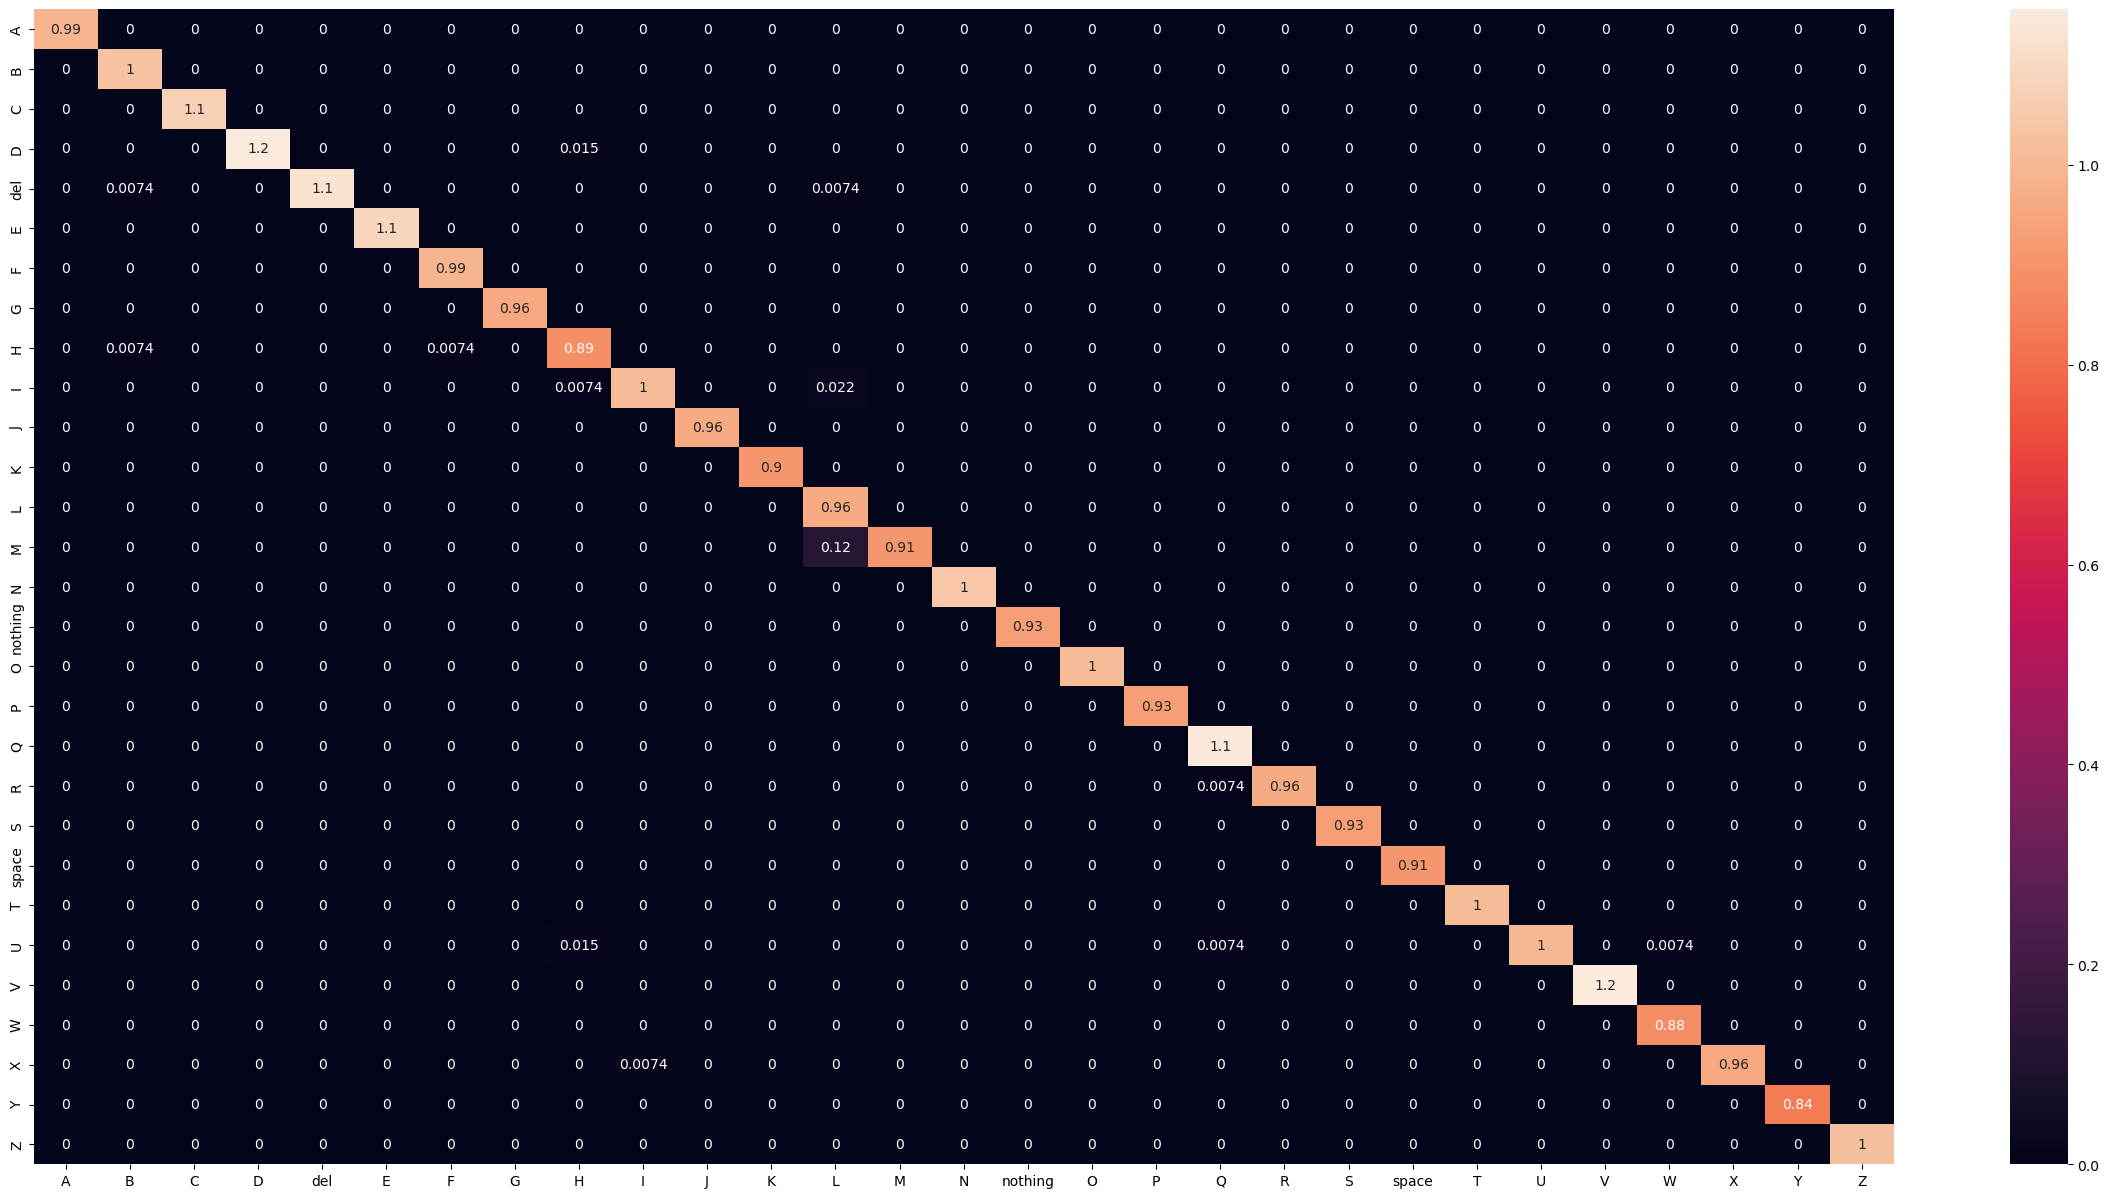

In [ ]:
# calling confusion matrix function to plot the visualisation.
make_confusion_matrix(resnet_y_pred , resnet_y_true )

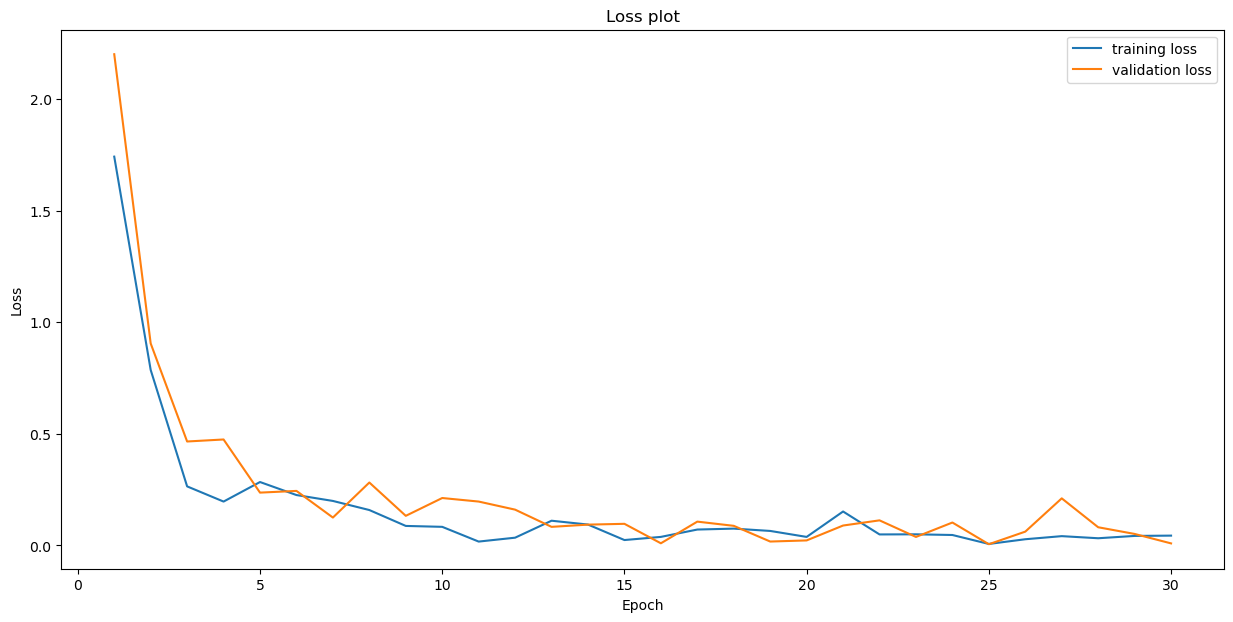

In [ ]:
# plotting both training and validation loss values 

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(epochs, resnet_training_loss, label = 'training loss')
plt.plot(epochs,resnet_val_loss, label = 'validation loss')
plt.legend()

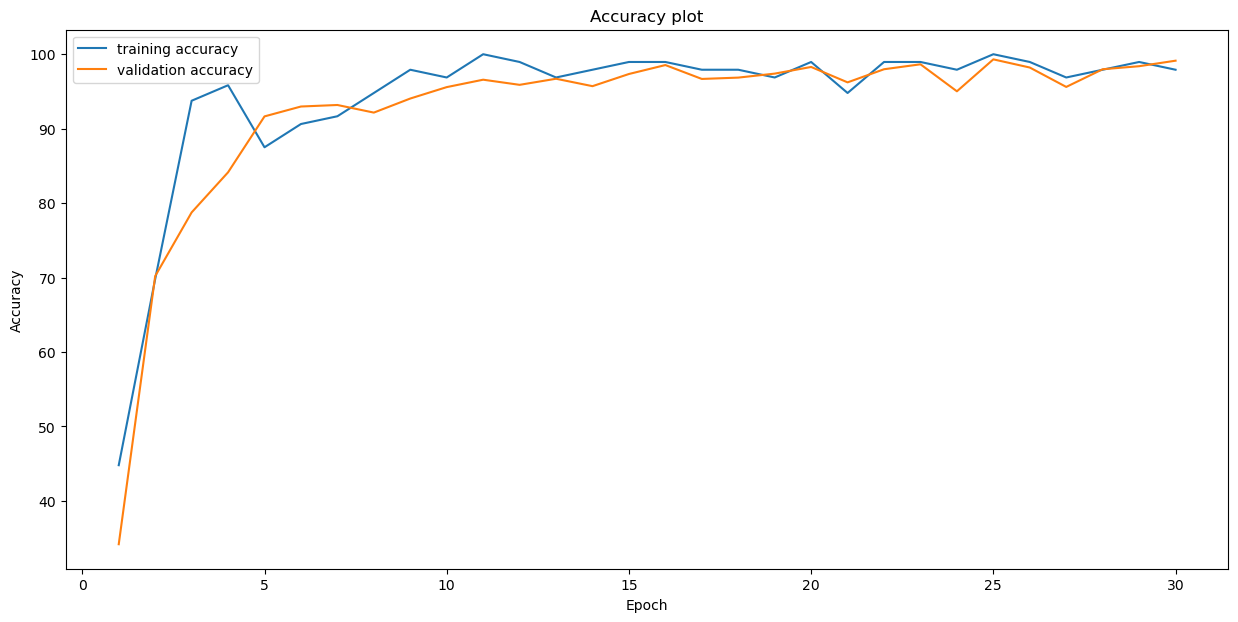

In [ ]:
# plotting both training and validation accuracy values

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(epochs, resnet_training_accuracies, label = 'training accuracy')
plt.plot(epochs,resnet_val_accuracies, label = 'validation accuracy')
plt.legend()

In [ ]:
# calculating different evaluation metrics like F1Score, Precision and Recall.
print("F1 SCORE :-", f1_score(resnet_y_true, resnet_y_pred, average="macro"))
print("PRECISION :-", precision_score(resnet_y_true, resnet_y_pred,average="macro"))
print("RECALL :-", recall_score(resnet_y_true, resnet_y_pred,average="macro"))

F1 SCORE :- 0.9918779683312912
PRECISION :- 0.9923001174202286
RECALL :- 0.9920751413932968
